# Clustering and Visualization of Phoebe dataset

## Components
* Create dataset with every row linked to the image it was generated from
    * Will need to extract images from videos like this:
    `ffmpeg -ss 00:23:00 -i video.mp4 -frames:v 1 out_time.jpg`


In [174]:
from importlib import reload  # Not needed in Python 2
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
DATASET_FILE = "Phoebe_dataset4.zip"
full_path = os.path.abspath(DATASET_FILE[:-4])
if not os.path.exists(full_path):
    !unzip -o $DATASET_FILE;

---
## Load datasets
### Helper functions

In [175]:
# import os, os.path
from typing import List, Dict, Union, Any
import csv
import uuid
import re
import time
import datetime
import logging

# Paths
PATH_DATASET = "Phoebe_dataset4"
PATH_AU_INTENSITY = "single_person_au_intensity"
PATH_AU_PRESENCE = "single_person_au_presence"
PATH_TRAIN = "train"
PATH_TEST = "test"
PATH_TRAINING_VIDEOS = PATH_DATASET + "/videos/train"
PATH_PROCESSED_IMAGES = PATH_DATASET + "/processed_images"
PATH_TRAINING_CSV = f"./{PATH_DATASET}/{PATH_AU_INTENSITY}/{PATH_TRAIN}/"

# General
EXT_MP4 = "mp4"

# Stores
IMAGE_STORE = {}

log = logging.getLogger()
log.setLevel(logging.DEBUG)

if not os.path.isdir(PATH_PROCESSED_IMAGES):
    os.mkdir(PATH_PROCESSED_IMAGES)

In [176]:
def load_dataset(filename: str) -> List[Union[str, float]]:
    """Load dataset for a single csv/video pair.
    
    :param filename: name of video and csv without an extension.
    
    :return: result dataset for csv/video pair.
    """
    # Load csv with python library so that first column may be removed.
    print(filename)
    raw_data = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        
        for index, row in enumerate(reader):
            if index == 0:
                row = [x.strip() for x in row]
                # Rename column row
                row[0] = "frame"
                
                # Create a new column to save filename the row came from.
                # This is used to extract image when needed (filename + frame are needed)
                row.insert(0, "filename")
                
            elif row[0] != "":
                # Create an image for every row and add to dictionnary {id: path}
                filename_without_ext: str = re.findall(r"[0-9]+", filename)[-1]
                row.insert(0, filename_without_ext)
            raw_data.append(row)
    
    return raw_data

def create_full_dataset(training_files) -> List[Union[str, float]]:
    """Load dataset for every csv/video pair.
    
    :param training_files: list of csv files.
    
    :return: full dataset results
    """
    assert(isinstance(training_files, list)) 
    full_dataset = []
    for file in training_files:
        dataset = load_dataset(file)
        if len(full_dataset) == 0:
            full_dataset = dataset
        else:
            full_dataset.extend(dataset[1:])
    return full_dataset

### Get image
If image has not been extracted for given id, extract it from corresponding video. This is made easy because the matrix stores the video name (without the extension) and the frame number.

Pass the entire row of data to the `extract_image_for_frame` function in order to get the correct frame.

In [177]:
from IPython.display import display, Image
import datetime

# %%capture
def extract_image_for_frame(image_path: str, video_name: str, frame: str):
    """Extracts a frame from a video given a timestamp in seconds.
    
    :param orig_filename: name of video for which timestamp applies
    :param row_id: id of row and image
    
    :return: name of the image without its extension.
    """

    video_filepath = PATH_TRAINING_VIDEOS + f"/{video_name}.{EXT_MP4}"
    
    # Data was sampled at about 30fps. Get time at which it is in the video
    time_in_seconds = (1/30) * frame
    time_datetime = datetime.timedelta(seconds=time_in_seconds)
    
    # log.debug(f"Extracting frame at time {time_datetime} from path {video_filepath}")        
    # command = f"ffmpeg -i {video_filepath} -r 30 {image_path}.jpg"
    
    command = f"ffmpeg -i {video_filepath} -ss {time_datetime} -vframes 1 {image_path} -n"
    # log.debug(f"Running command: {command}")

    print(f"### ")
    !$command;

def image_path_for_row(row: List[Any]):
    """Return path of image for a row"""
    video_name = int(row[0])
    frame = int(row[0])
    image_name = f"{video_name:03}{frame:03}"
    image_path = PATH_PROCESSED_IMAGES + "/" + image_name + ".jpeg"
    if not os.path.exists(image_path):
        extract_image_for_frame(image_path, video_name, frame)
    return image_path
    
def show_image_from_row(row: List[Any]):
    """
    :param row: a row of data from full_dataset (a python list which contains the header). This
        is a bit ugly, but it is the way I started it.
    :param show: whether to directly print the image
    
    TODO: perhaps revise calling interface.
    """
    # log.debug(f"### Getting image for row: {row}")
    
    image_path = image_path_for_row(row)
    
    try:
        image = Image(filename=f'{image_path}.jpg')
        display(image)
    except IOError as e:
        print(e)      

### Run dataset preparation pipeline

In [178]:
# %%capture
training_files: List[str] = [f"{PATH_TRAINING_CSV}{name}" for 
                             name in os.listdir(f"{PATH_TRAINING_CSV}") if 
                             name[-4:] == ".csv"]

print(training_files[0:2])
# Load datasets
full_dataset = create_full_dataset(training_files)

['./Phoebe_dataset4/single_person_au_intensity/train/6.csv', './Phoebe_dataset4/single_person_au_intensity/train/40.csv']
./Phoebe_dataset4/single_person_au_intensity/train/6.csv
./Phoebe_dataset4/single_person_au_intensity/train/40.csv
./Phoebe_dataset4/single_person_au_intensity/train/41.csv
./Phoebe_dataset4/single_person_au_intensity/train/7.csv
./Phoebe_dataset4/single_person_au_intensity/train/43.csv
./Phoebe_dataset4/single_person_au_intensity/train/5.csv
./Phoebe_dataset4/single_person_au_intensity/train/4.csv
./Phoebe_dataset4/single_person_au_intensity/train/42.csv
./Phoebe_dataset4/single_person_au_intensity/train/46.csv
./Phoebe_dataset4/single_person_au_intensity/train/1.csv
./Phoebe_dataset4/single_person_au_intensity/train/47.csv
./Phoebe_dataset4/single_person_au_intensity/train/3.csv
./Phoebe_dataset4/single_person_au_intensity/train/45.csv
./Phoebe_dataset4/single_person_au_intensity/train/44.csv
./Phoebe_dataset4/single_person_au_intensity/train/50.csv
./Phoebe_datas

In [179]:
print(len(full_dataset))
print(full_dataset[0:5])

3217
[['filename', 'frame', 'face_id', 'confidence', 'success', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r'], ['6', '0', '0', '0.98', '1', '0.11', '0.0', '0.0', '0.0', '1.33', '2.09', '0.0', '1.1', '1.62', '0.08', '0.1', '0.15', '0.0', '0.0', '0.0', '0.29', '0.0'], ['6', '1', '0', '0.98', '1', '0.04', '0.0', '0.13', '0.08', '1.42', '2.2', '0.13', '1.14', '1.61', '0.03', '0.14', '0.4', '0.0', '0.0', '0.12', '0.1', '0.01'], ['6', '2', '0', '0.98', '1', '0.0', '0.0', '0.13', '0.08', '1.43', '2.08', '0.13', '1.02', '1.53', '0.02', '0.1', '0.35', '0.17', '0.0', '0.23', '0.14', '0.13'], ['6', '3', '0', '0.98', '1', '0.0', '0.0', '0.08', '0.15', '1.43', '1.84', '0.07', '0.86', '1.36', '0.06', '0.01', '0.12', '0.17', '0.08', '0.18', '0.28', '0.3']]


In [180]:
# Images in Image datastore are "fileid_frame"
show_image_from_row(full_dataset[1])

[Errno 2] No such file or directory: 'Phoebe_dataset4/processed_images/006006.jpeg.jpg'


In [181]:
count = 3
print(f"First {count} rows of dataset:\n")
for i in range(0, count):
    print(str(full_dataset[i]) + "\n")

First 3 rows of dataset:

['filename', 'frame', 'face_id', 'confidence', 'success', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']

['6', '0', '0', '0.98', '1', '0.11', '0.0', '0.0', '0.0', '1.33', '2.09', '0.0', '1.1', '1.62', '0.08', '0.1', '0.15', '0.0', '0.0', '0.0', '0.29', '0.0']

['6', '1', '0', '0.98', '1', '0.04', '0.0', '0.13', '0.08', '1.42', '2.2', '0.13', '1.14', '1.61', '0.03', '0.14', '0.4', '0.0', '0.0', '0.12', '0.1', '0.01']



---
## Preprocess and cleanup data
- [X] Remove rows with confidence < 85
- [X] Remove rows with empty value(s)

### Compare ML algorithms for
- [ ] Scaled AU between 0 and 1, and unscaled AUs

In [182]:
from pprint import pprint

CONFIDENCE_LEVEL = 0.85

full_dataset_header = full_dataset[0]
keys_full_dataset = {j: i for i, j in enumerate(full_dataset_header)}
index_to_key = {i: j for i, j in enumerate(full_dataset_header)}

print(f"keys_full_dataset:")
pprint(keys_full_dataset)

print(f"type(full_dataset): \t{type(full_dataset)}")      

# NOTE: because full_dataset stores strings in the first row, it must be skipped
# in list comprehensions. Furthermore, the strings also need to be cast to whatever
# format they are being compared to (int, float).

# Only keep rows that have "success = 1"
full_dataset_all_success = [x for x in full_dataset[1:] 
                            if int(x[keys_full_dataset["success"]]) == 1]
log.debug("Removed {} rows with 'success = 0'".format(
    len(full_dataset) - len(full_dataset_all_success)))

# Only keep rows that have "confidence > 0.85"
full_dataset_good_confidence = [x for x in full_dataset_all_success[1:] 
                                if float(x[keys_full_dataset["confidence"]]) >= CONFIDENCE_LEVEL]
log.debug("Removed {} rows with 'confidence < 0'".format(
    len(full_dataset_all_success) - len(full_dataset_good_confidence)))

# Do not edit final_dataset. It is there to keep indempotency in case more filters
# need to be added above. The final dataset has all unwanted rows removed, but still
# has the header row.
final_dataset = full_dataset_good_confidence

06:01:11 DEBUG:Removed 86 rows with 'success = 0'
06:01:11 DEBUG:Removed 43 rows with 'confidence < 0'


keys_full_dataset:
{'AU01_r': 5,
 'AU02_r': 6,
 'AU04_r': 7,
 'AU05_r': 8,
 'AU06_r': 9,
 'AU07_r': 10,
 'AU09_r': 11,
 'AU10_r': 12,
 'AU12_r': 13,
 'AU14_r': 14,
 'AU15_r': 15,
 'AU17_r': 16,
 'AU20_r': 17,
 'AU23_r': 18,
 'AU25_r': 19,
 'AU26_r': 20,
 'AU45_r': 21,
 'confidence': 3,
 'face_id': 2,
 'filename': 0,
 'frame': 1,
 'success': 4}
type(full_dataset): 	<class 'list'>


### Show image from index

In [183]:
def image_path_from_index(index: int):
    # full_dataset/final_dataset has +1 row than numpy array index was pulled from
    path = image_path_for_row(final_dataset[index + 1])
    return path

### Train first GMM

In [184]:
from sklearn import preprocessing
import numpy as np

only_AU_info = [x[keys_full_dataset["AU01_r"]:] 
                for x in final_dataset[1:]]

X_train = np.array(only_AU_info, dtype=float)

# # Scale AUs
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train = min_max_scaler.fit_transform(X_train)
    
print(f"X_train.shape: \t\t{X_train.shape}\n")
# Just make sure only the 17 AU are there
assert(X_train.shape[1] == 17)

count = 3
print(f"First {count} rows of X_train:")
for i in range(0, count):
    print(str(X_train[i]) + "\n")

X_train.shape: 		(3087, 17)

First 3 rows of X_train:
[0.         0.         0.03693182 0.04761905 0.42058824 0.492891
 0.07926829 0.3100304  0.478125   0.00566572 0.02061856 0.07070707
 0.11971831 0.         0.06571429 0.035      0.05963303]

[0.         0.         0.02272727 0.08928571 0.42058824 0.43601896
 0.04268293 0.26139818 0.425      0.01699717 0.00206186 0.02424242
 0.11971831 0.01965602 0.05142857 0.07       0.13761468]

[0.         0.01777778 0.01704545 0.04166667 0.39705882 0.41943128
 0.04878049 0.24012158 0.421875   0.05382436 0.         0.00808081
 0.11971831 0.02702703 0.12285714 0.1125     0.16513761]



---
## Gausian Mixture Model

In [185]:
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

06:01:11 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


First 3 trained rows of probabilities table: 
[[0.    0.    0.    0.    0.    0.    0.    0.    0.275 0.    0.    0.725
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]
Max probability value of any category for 100 row: 
[0.72460163 1.         1.         0.99999922 0.99995768 0.99986933
 0.85047164 0.69877013 0.93120484 0.96873547 0.91260719 0.83223052
 0.99999999 0.99999976 0.99999974 0.98505334 0.95292211 0.98979119
 0.97526227 0.9478128  0.99059493 0.99999561 0.95199768 0.9909419
 1.         0.99418756 0.99989534 0.99993448 0.99997341 0.99941478
 0.9979803  0.99961063 0.99990541 0.99999825 0.98870451 0.999966
 0.99999977 0.99999999 0.99999706 0.99996293 0.99915886 0.99999963
 0.99981472 0.9904386  0.99847872 0.97865008 0.99463402 1.
 1.         1.         1.         1.         0.99999998 0.986

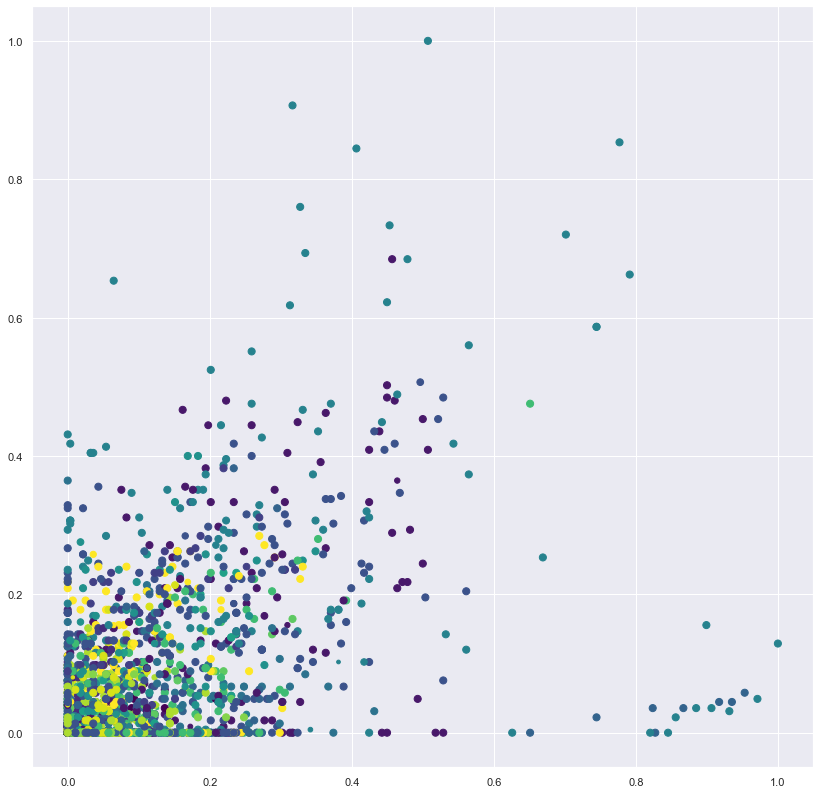

In [186]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.mixture import GaussianMixture as GMM


X_train_with_labels = X_train

gmm = GMM(n_components=17).fit(X_train)
probs = gmm.predict_proba(X_train) 
count = 3
print(f"First {count} trained rows of probabilities table: \n{probs[:count].round(3)}")

# Print maximum probability for every row. The closest it is to 1, the more
# certain GMM is about that point (=row).
count = 100
maxInRows = np.amax(probs, axis=1)
print(f"Max probability value of any category for {count} row: \n{maxInRows[:count]}")


labels = gmm.predict(X_train)
size = 50 * probs.max(1) ** 2 # square emphasizes differences
plt.figure(figsize=(14,14))
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, s=size, cmap='viridis');

The current GMM does not show any clear blobs. Rather, the data seems to be scattered heterogeneously. However, I can see in the probabilities for individual points that each point has a high probability of belonging to a single cluster. Therefore, I think that the high level of dimensions of the data is problematic.

### Determine optimal number of components

/Users/leo/workspace/cmpt419/CMPT419-A2/venv/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


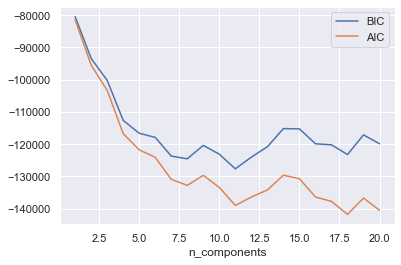

In [187]:
# Turn off DEBUG logs otherwise the below graph fills the logs...
logging.basicConfig(level=logging.ERROR)

n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(X_train)
          for n in n_components]
plt.plot(n_components, [m.bic(X_train) for m in models], label='BIC') 
plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC') 
plt.legend(loc='best')
plt.xlabel('n_components');

The best number of components is about 17. This makes sense since there are 17 parameters in the training data.

### Most representative image per component

Probabilities for every row: 
[[0.    0.    0.    0.    0.    0.    0.    0.    0.275 0.    0.    0.725
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]

Max values for the 17 AU columns: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Tuple (AU_num, row_num) for max value of every AU column: 
[(0, 1222), (1, 625), (2, 1955), (3, 815), (4, 3030), (5, 1823), (6, 50), (7, 379), (8, 1055), (9, 1843), (10, 652), (11, 1415), (12, 1618), (13, 103), (14, 2454), (15, 2432), (16, 551)]

ROW_X: 		[0.209 0.049 0.    0.411 0.009 0.635 0.03  0.    0.303 0.646 0.641 0.972
 0.    0.83  0.    0.458 0.   ]
ROW_probs: 	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


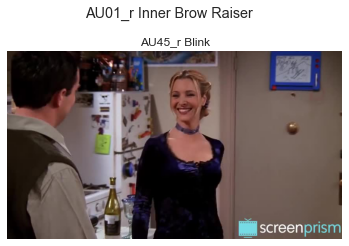

### 
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.59)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags=-fno-stack-check --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  

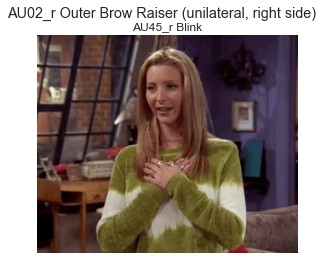

### 
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.59)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags=-fno-stack-check --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  

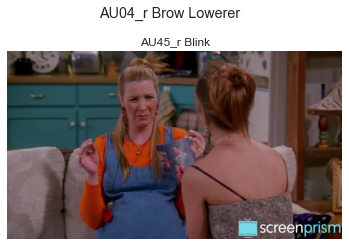

ROW_X: 		[0.022 0.009 0.062 0.155 0.021 0.064 0.043 0.377 0.325 0.048 0.184 0.16
 0.    0.069 0.034 0.288 0.28 ]
ROW_probs: 	[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


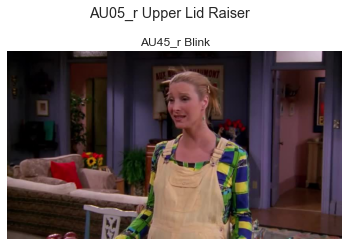

### 
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.59)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags=-fno-stack-check --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  

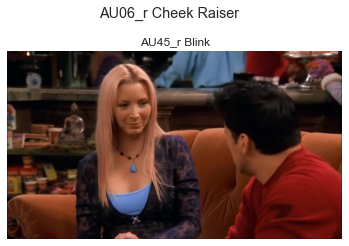

ROW_X: 		[0.745 0.022 0.509 0.31  0.    0.204 0.006 0.222 0.    0.006 0.128 0.204
 0.    0.155 0.    0.    0.216]
ROW_probs: 	[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


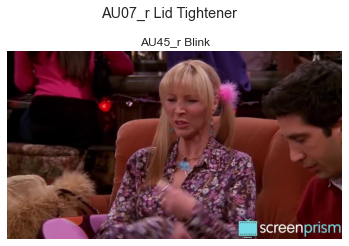

### 
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.59)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags=-fno-stack-check --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  

FileNotFoundError: [Errno 2] No such file or directory: 'Phoebe_dataset4/processed_images/041041.jpeg'

<Figure size 432x288 with 0 Axes>

In [188]:
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

# AU to descriptor dict
AU_DESCRIPTOR = {
    "AU01": "Inner Brow Raiser",
    "AU02": "Outer Brow Raiser (unilateral, right side)",
    "AU04": "Brow Lowerer",
    "AU05": "Upper Lid Raiser",
    "AU06": "Cheek Raiser",
    "AU07": "Lid Tightener",
    "AU09": "Nose Wrinkler",
    "AU10": "Upper Lip Raiser",
    "AU12": "Lip Corner Puller",
    "AU14": "Dimpler",
    "AU15": "Lip Corner Depressor",
    "AU17": "Chin Raiser",
    "AU20": "Lip stretcher",
    "AU23": "Lip Tightener",
    "AU25": "Lips part",
    "AU26": "Jaw Drop",
    "AU45": "Blink",
}

# Turn on DEBUG logs otherwise the below graph fills the logs...
logging.basicConfig(level=logging.DEBUG)

# Gaussian probabilities for every row of data
probs = gmm.predict_proba(X_train) 
print(f"Probabilities for every row: \n{probs[:3].round(3)}\n")

# Find the row index of the highest value for every column. The row index can be linked back to its image.
maxval = np.max(probs, axis=0)
print(f"Max values for the 17 AU columns: {maxval}\n")

# Transpose probability table of all points. Finding the index of the highest val in every list
# is equivalent to finding the row index X_train.
probs_pd = pd.DataFrame(probs)

# [AU_num, row_num]
indices: List[Tuple[int]] = []
    
for i in range (0, 17):
    indices.append((i, probs_pd[i].argmax()))
print(f"Tuple (AU_num, row_num) for max value of every AU column: \n{indices}\n")

# To access key name from dictionary, account for 5 deleted columns that precede AU columns
ACCOUNT_FOR_5_MISSING_HEADER_COLS = 5
# Show image for every AU

def get_row_metadata(row_index: int):
    """Return probabilities for each class"""
    # Get row from probability matrix
    
    row_X = X_train[row_index]
    row_probs = probs[row_index,]
    
    print(f"ROW_X: \t\t{row_X.round(3)}")
    print(f"ROW_probs: \t{row_probs.round(3)}")
    # Show all probabilities > 50
    pass
    
for i in indices:
    plt.figure()
    img_path = image_path_from_index(i[1])
    img=mpimg.imread(img_path)
    plt.axis('off')
    plt.grid(b=None)
    imgplot = plt.imshow(img)
    
    AU_type = index_to_key[i[0] + ACCOUNT_FOR_5_MISSING_HEADER_COLS]
    title = AU_type + " " + AU_DESCRIPTOR[AU_type[:4]]
    
    metadata = get_row_metadata(i[1])
    plt.suptitle(title)
    plt.title(subtitle)
    plt.show()

## Apply UMAP
Reduce dimensions of the dataset.